In [58]:
import math
import collections
from matplotlib import pyplot as plt
from random import *
from collections import Counter, defaultdict
from probability import inverse_normal_cdf
from linear_algebra import shape, get_row, get_column, make_matrix, \
    vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply

from stats import correlation, standard_deviation, mean
import dateutil.parser

In [59]:
def bucketize(point,bucket_size):
    return bucket_size * math.floor(point/bucket_size)

In [60]:
def make_histogram(points,bucket_size):
    return collections.Counter(bucketize(point,bucket_size) for point in points)

In [61]:
def plot_histogram(points,buckect_size,title = ""):
    histogram = make_histogram(points,buckect_size)
    plt.bar(histogram.keys(),histogram.values(),width=buckect_size)
    plt.title(title)
    plt.show()


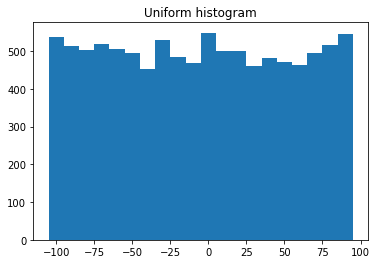

In [62]:


uniform = [200 * random() - 100 for _ in range(10000)]

normal = [57 * inverse_normal_cdf(random()) for _ in range(100000)]



plot_histogram(uniform,10,"Uniform histogram")

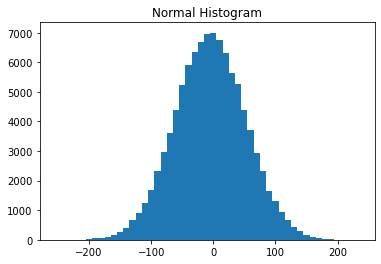

In [63]:
plot_histogram(normal,10 , "Normal Histogram")

Ahora vamos a trbajar con dos dimensiones

In [64]:
def random_normal():
    return inverse_normal_cdf(random())

xs = [random_normal() for  _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x +random_normal() / 2 for x in xs ]

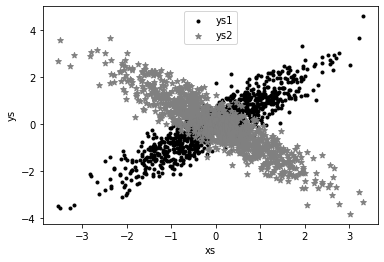

In [65]:
plt.scatter(xs,ys1,marker='.',color='black' , label = 'ys1')
plt.scatter(xs,ys2,marker='*',color='gray' , label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)

Más dimensiones

In [66]:


def correlation_matrix(data):
    _, num_columns = shape(data)
    def matrix_entry(i,j):
        return correlation(get_column(data,1), get_column(data,j))
    return make_matrix(num_columns,num_columns,matrix_entry)



In [67]:
num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

data = [random_row()
    for _ in range(num_points)]

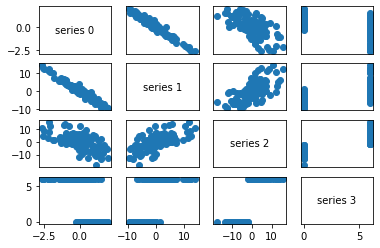

In [68]:
_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

### Manipulacion de datos

En esta seccion vamos a utilizar un par de herramientas para poder utilizar un diccionario

In [69]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }

def percent_price_change(yesterday, today):
    return today["closing_price"]  / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

In [79]:
from datetime import datetime
datum1 = [{
    'closing_price': 120.9,
    'date': datetime.strptime('11/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
},
{
    'closing_price': 150.9,
    'date': datetime.strptime('14/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
},
{
    'closing_price': 190.9,
    'date': datetime.strptime('16/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
}]



percent_price_change(datum1[0], datum1[1])


0.24813895781637707

In [80]:
day_over_day_changes(datum1)

[{'symbol': 'AAPL',
  'date': datetime.datetime(2021, 12, 14, 0, 0),
  'change': 0.24813895781637707},
 {'symbol': 'AAPL',
  'date': datetime.datetime(2021, 12, 16, 0, 0),
  'change': 0.2650762094102055}]